In [1]:
import numpy as np
import pandas as pd
import mne
import csv, json
import datetime
import matplotlib.pyplot as plt

In [2]:
file_name = 'Veh70_02202015'

In [3]:
edf = mne.io.read_raw_edf('EDF_CSV_JSON_Example/'+file_name+'.edf', preload = True)

Extracting EDF parameters from /home/maikito/Documents/master ciencia de datos/ADS/Project/EDF_CSV_JSON_Example/Veh70_02202015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10800499  =      0.000 ... 21600.998 secs...


## Manual Undersampling

In [4]:
def edf_to_dataset(edf_path, scores_path):
    edf = mne.io.read_raw_edf(edf_path)
    sampling_rate = int(edf.info['sfreq'])
    name = datetime.datetime.utcfromtimestamp(edf.info['meas_date'][0]).strftime('%Y-%m-%d %H:%M:%S')
    
    header = (','.join(edf.ch_names)).split(',')
    df = edf.get_data().T
    
    scores = np.squeeze( pd.read_excel(scores_path, keep_default_na=False).values )
    values_per_window = int(df.shape[0]/scores.shape[0])
    num_windows = scores.shape[0]
    
    df = df[:num_windows*values_per_window]
    df = np.reshape(df, newshape=(num_windows, values_per_window, 2))

    scores[scores=='D'] = 'WA'
    
    return df, scores
def labels_to_onehot(Y, categories = {}):
    Y = Y.copy()
    count = 0
    for i in range(len(Y)):
        value = Y[i]
        if not value in categories:
            categories[value] = count
            count += 1
        Y[i] = categories[value]

    Y = Y.astype(int)
    Y_onehot = np.zeros((Y.shape[0], len(categories)))
#     print(Y_onehot.shape)
#     print(categories)
    Y_onehot[np.arange(Y.shape[0]), Y] = 1

    return Y_onehot, categories

In [5]:
sample_folder = './EDF_CSV_JSON_Example/'
file_name = 'Veh70_02202015'
X, Y = edf_to_dataset(sample_folder+file_name+'.edf', sample_folder + file_name+'.xls')

Extracting EDF parameters from /home/maikito/Documents/master ciencia de datos/ADS/Project/EDF_CSV_JSON_Example/Veh70_02202015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [7]:
Y_onehot, categories = labels_to_onehot(Y)
print(Y_onehot.shape)
print(categories)

(2160, 6)
{'NA': 0, 'WA': 1, 'W': 2, 'NR': 3, 'RA': 4, 'R': 5}


In [8]:
X.shape

(2160, 5000, 2)

### Undersample

In [51]:

def undersample(X, new_freq = 50, current_freq = 500, verbose = False):
    if current_freq % new_freq > 0: 
        print('(current_freq / new_frequency) should be an integer')
        return 0
    ratio = new_freq / current_freq
    num_points = int(X.shape[1] * ratio)
    indices = np.arange(start = 0, stop = X.shape[1], step = int(ratio**-1))
    X_new = X[:,indices,:]
    if verbose: 
        print('Old dimensions:',X.shape)
        print('New dimensions:',X_new.shape)
    return X_new

def remove_epochs(X, verbose = False):
    X_new = []
    EEG = [] ; EMG = [];
    for epoch in range(X.shape[0]):
        EEG.append(X[epoch, :, 0])
        EMG.append(X[epoch, :, 1])
    EEG = np.hstack(tuple(EEG))
    EMG = np.hstack(tuple(EMG))
    X_new = np.squeeze(np.dstack((EEG,EMG)))
    if verbose: print('Dimensions (no epochs):',X_new.shape)
    return X_new



In [42]:
frequency_undersampled = 500
X_undersampled = undersample(X, frequency_undersampled, verbose = True)
X_no_epochs = remove_epochs(X_undersampled, verbose = True)

Old dimensions: (2160, 5000, 2)
New dimensions: (2160, 5000, 2)
Dimensions (no epochs): (10800000, 2)


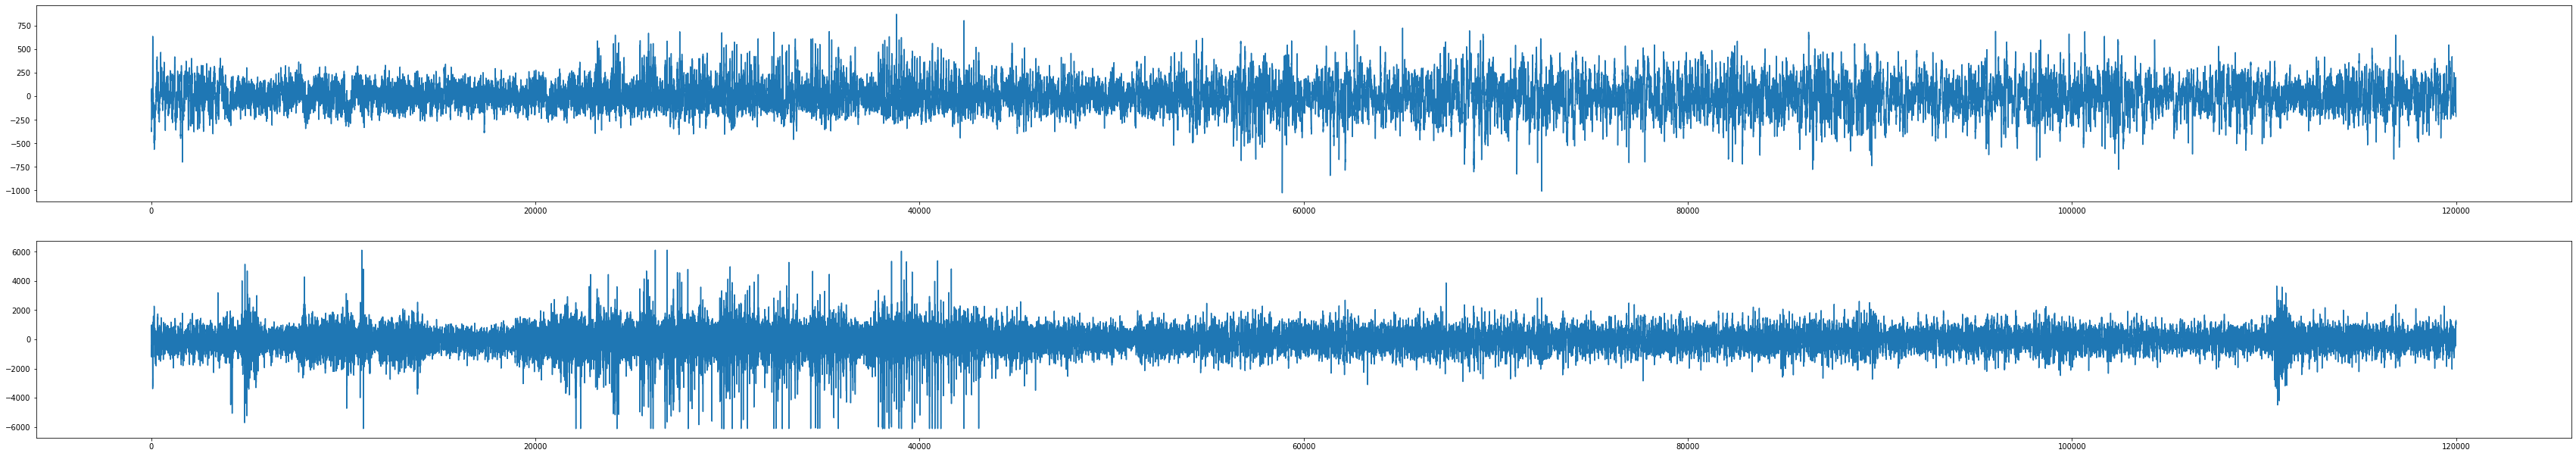

In [44]:
# plt.plot(X_no_epochs[0:(500*10*24),0])
# fig = plt.gcf()
# fig.set_size_inches(60, 10.5)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(X_no_epochs[0:(frequency_undersampled*10*24),0])
ax2.plot(X_no_epochs[0:(frequency_undersampled*10*24),1])
fig = plt.gcf()
fig.set_size_inches(60, 10.5)

In [40]:
frequency_undersampled = 250
X_undersampled = undersample(X, frequency_undersampled, verbose = True)
X_no_epochs = remove_epochs(X_undersampled, verbose = True)

Old dimensions: (2160, 5000, 2)
New dimensions: (2160, 2500, 2)
Dimensions (no epochs): (5400000, 2)


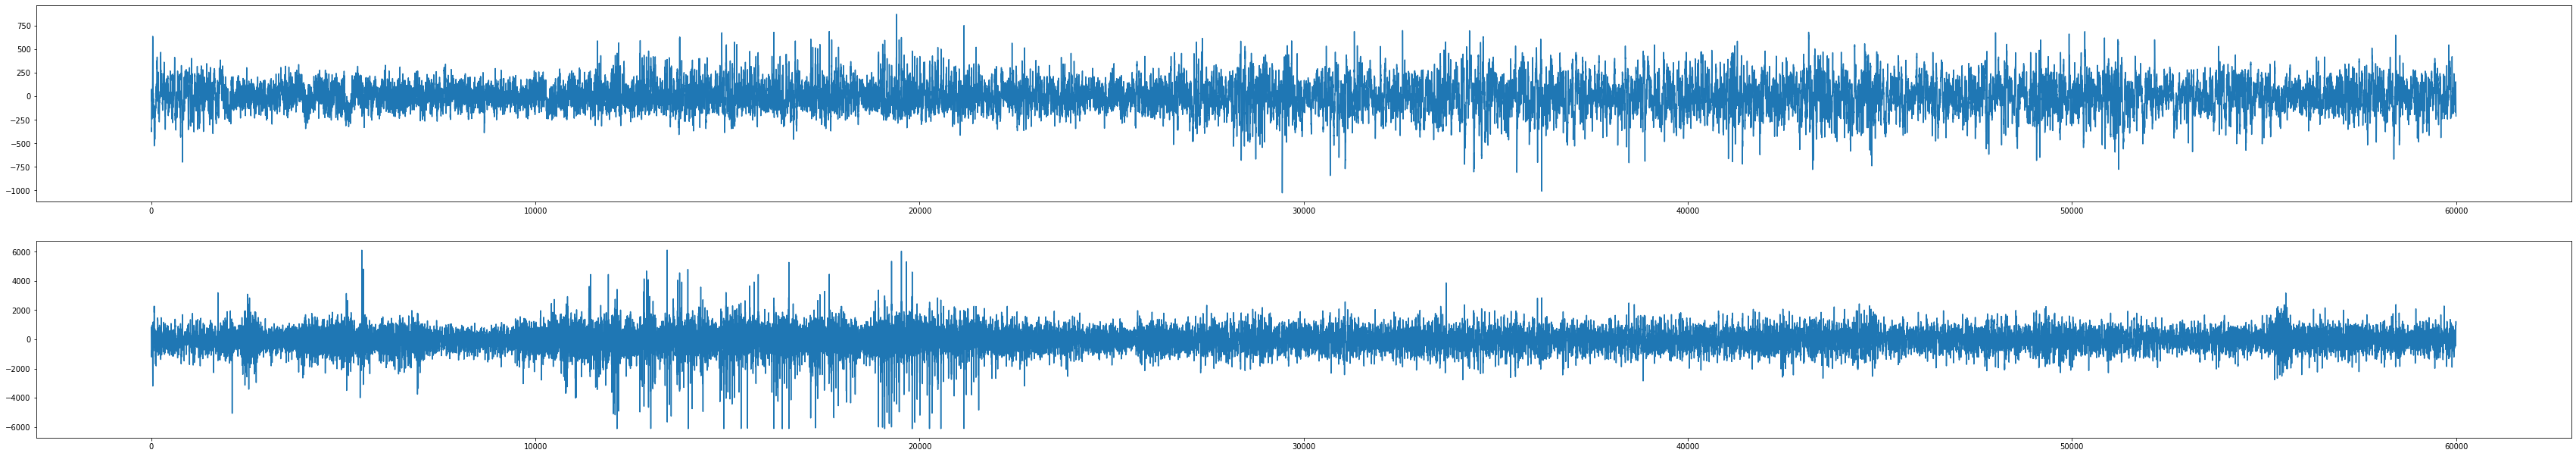

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(X_no_epochs[0:(frequency_undersampled*10*24),0])
ax2.plot(X_no_epochs[0:(frequency_undersampled*10*24),1])
fig = plt.gcf()
fig.set_size_inches(60, 10.5)

In [45]:
frequency_undersampled = 100
X_undersampled = undersample(X, frequency_undersampled, verbose = True)
X_no_epochs = remove_epochs(X_undersampled, verbose = True)

Old dimensions: (2160, 5000, 2)
New dimensions: (2160, 1000, 2)
Dimensions (no epochs): (2160000, 2)


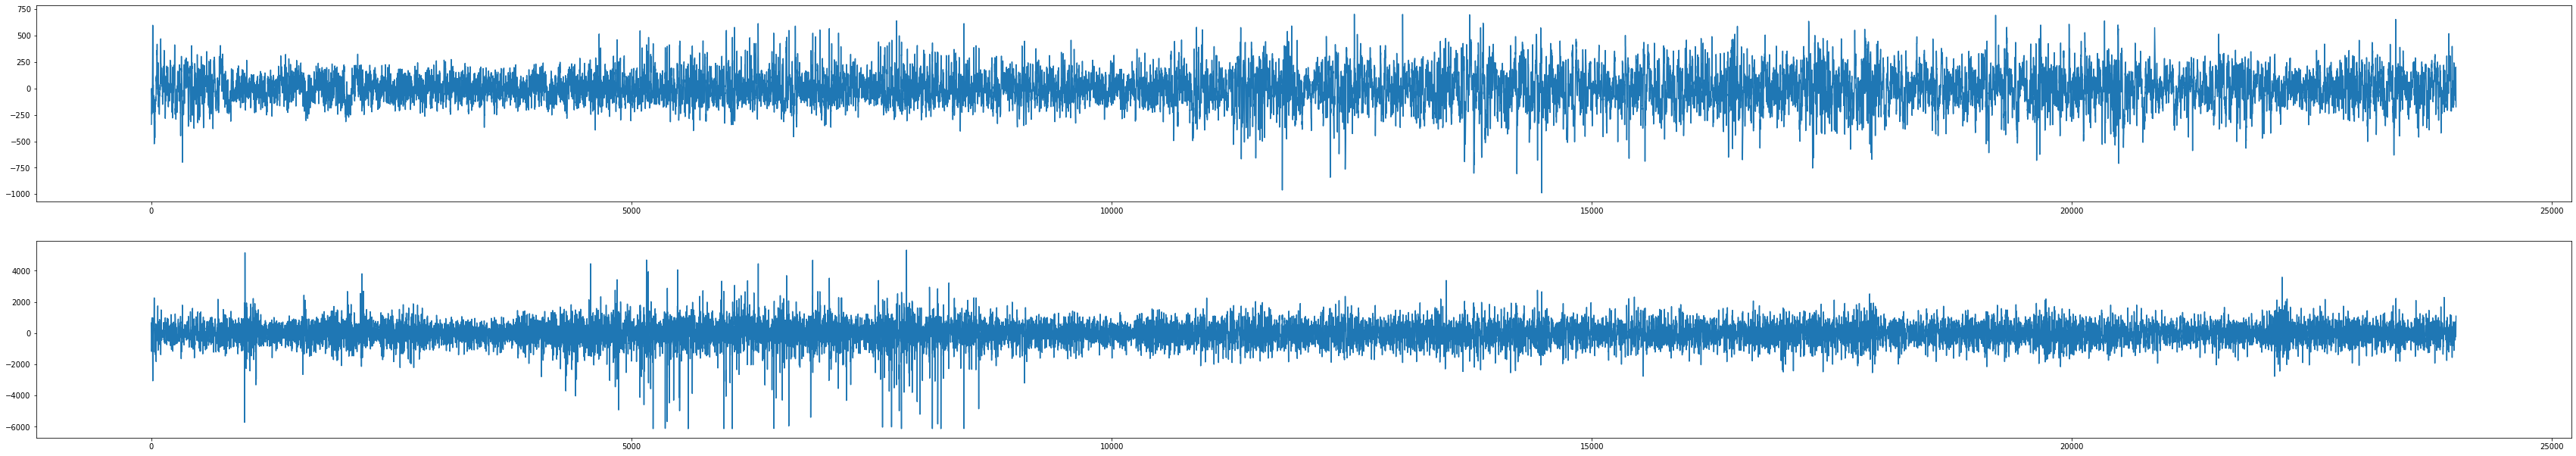

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(X_no_epochs[0:(frequency_undersampled*10*24),0])
ax2.plot(X_no_epochs[0:(frequency_undersampled*10*24),1])
fig = plt.gcf()
fig.set_size_inches(60, 10.5)

Old dimensions: (2160, 5000, 2)
New dimensions: (2160, 500, 2)
Dimensions (no epochs): (1080000, 2)


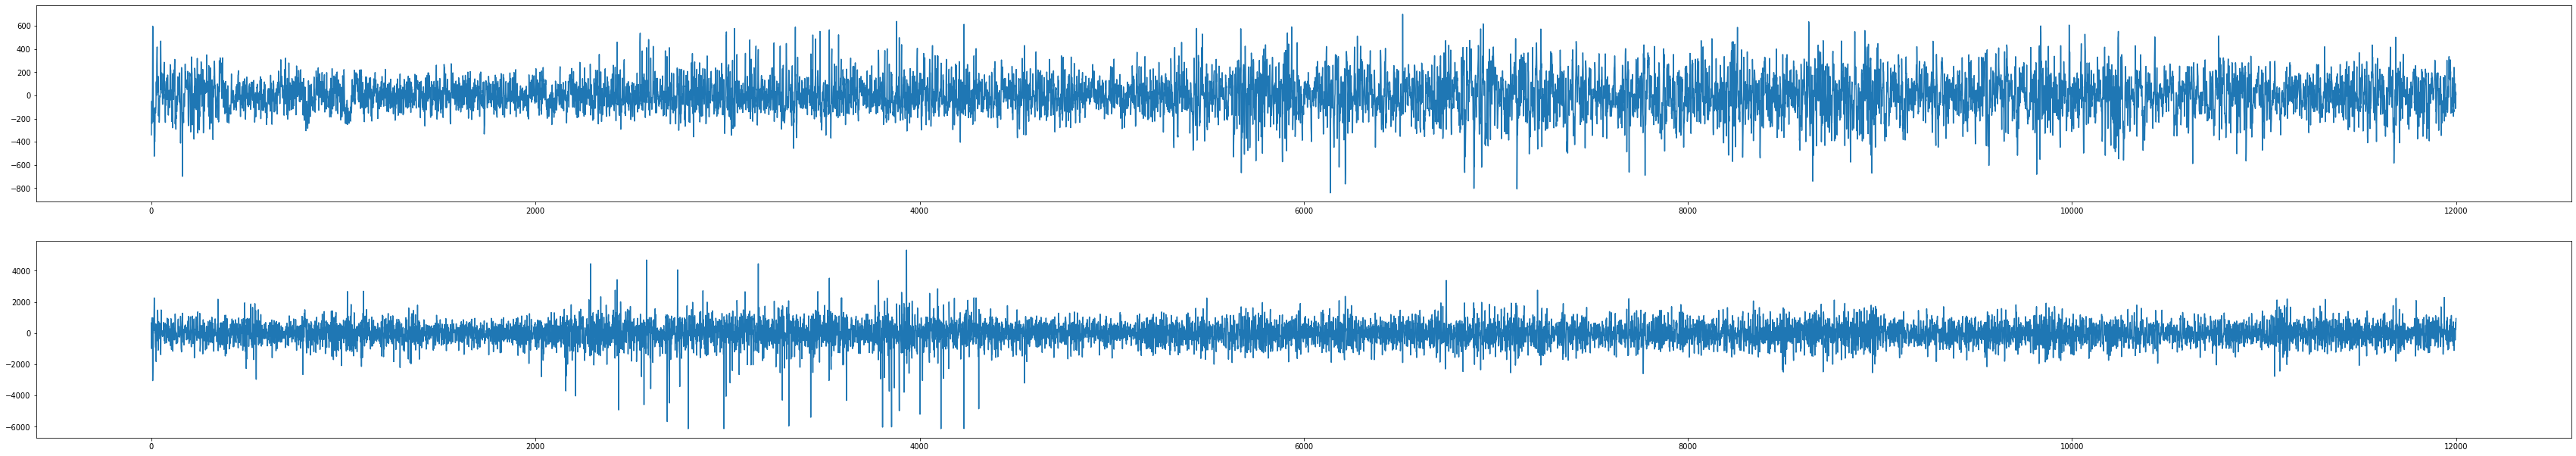

In [50]:
frequency_undersampled = 50
X_undersampled = undersample(X, frequency_undersampled, verbose = True)
X_no_epochs = remove_epochs(X_undersampled, verbose = True)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(X_no_epochs[0:(frequency_undersampled*10*24),0])
ax2.plot(X_no_epochs[0:(frequency_undersampled*10*24),1])
fig = plt.gcf()
fig.set_size_inches(60, 10.5)